In [1]:
#librerias
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Lectura de archivo para análisis
df = pd.read_csv("../data/output/cluster.csv")
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

## Análisis Clusters

Una vez asignado un cluster a cada cliente, se procede a analizar las características de cada grupo comparándolas con el total de la muestra. Para ello, se utiliza un índice relativo por variable, que permite identificar qué atributos están sobre- o infra-representados en cada cluster.


Para cada variable:
$
\text{Índice} = \frac{\text{Valor medio (o proporción) en el cluster}}{\text{Valor medio (o proporción) en el total}}
$

- Un valor mayor que 1 indica sobre-representación del atributo en el cluster.
- Un valor menor que 1 indica infra-representación.


*Objetivo del índice:*

- Identificar qué atributos definen más claramente cada cluster.
- Facilitar la interpretación de los segmentos para acciones estratégicas (campañas, productos, atención...).

## Indíces por Cluster

Este cuadro resume cómo se ha tratado cada tipo de variable para calcular los índices comparativos:

| Tipo de variable       | Método aplicado                                               |
|------------------------|----------------------------------------------------------------|
| **Continuas**          | Media por cluster / media total                               |
| **Ordinales**          | Media por cluster / media total (codificadas como 0,1,2,...)  |
| **Binarias (0 y 1)**   | Proporción con valor 0 y 1 en cluster / proporción total       |
| **Dummies**            | Proporción con valor 1 en cluster / proporción total           |

Definimos las variables,según el cuadro indicado para aplicarles sus respectivas transformaciones

In [3]:
continuas = ["Edad", "Family_Size", "Ingresos_anuales_brutos", "Digital_encuesta", "Dias_cliente"]
ordinales = ["Gastoscore", "Experiencia_laboral", "Generacion", "Gasto_medio_mensual_cuota"]
binarias_01 = ["Casado", "Graduado", "Abandono", "Genero"]
dummies = [col for col in df.columns if "Profesion_" in col or "Zona_" in col or "Campanna_" in col]

**Indices Continuas**

In [4]:
#(media por cluster / media total)
media_vars = continuas
media_cluster = df.groupby("cluster")[media_vars].mean()
media_total = df[media_vars].mean()
indices_media = media_cluster / media_total

**Indices Ordinales**

In [5]:
#(proporción de cada categoría por cluster / total)
indices_ordinales = pd.DataFrame(index=df['cluster'].unique())
for var in ordinales:
    categorias = sorted(df[var].dropna().unique())
    tabla_cluster = df.groupby("cluster")[var].value_counts(normalize=True).unstack().fillna(0)
    tabla_total = df[var].value_counts(normalize=True)
    for cat in categorias:
        indices_ordinales[f"{var}_{int(cat)}"] = tabla_cluster[cat] / tabla_total[cat]


**Indices Binarias**

In [6]:
# Índices para binarias (0 y 1)
indices_binarias = pd.DataFrame(index=df['cluster'].unique())
for col in binarias_01:
    for valor in [0, 1]:
        prop_cluster = df.groupby("cluster")[col].apply(lambda x: (x == valor).mean())
        prop_total = (df[col] == valor).mean()
        indices_binarias[f"{col}_{valor}"] = prop_cluster / prop_total

**Indices Dummies**

In [7]:
indices_dummies = pd.DataFrame(index=df['cluster'].unique())
for col in dummies:
    prop_cluster = df.groupby("cluster")[col].mean()
    prop_total = df[col].mean()
    indices_dummies[col] = prop_cluster / prop_total


**Indice Final**

In [8]:
#  Unir todos los resultados
indices = pd.concat([indices_media, indices_ordinales, indices_binarias, indices_dummies], axis=1)
indices = indices.sort_index()
indices = indices.round(2)
indices.name = "indices"

In [9]:
indices

,Edad,Family_Size,Ingresos_anuales_brutos,Digital_encuesta,Dias_cliente,Gastoscore_0,Gastoscore_1,Gastoscore_2,Experiencia_laboral_0,Experiencia_laboral_1,...,Zona_Centro,Zona_Este,Zona_Islas,Zona_Norte,Zona_Sur,Campanna_0,Campanna_1,Campanna_3,Campanna_4,Campanna_5
0,0.53,1.52,0.38,1.53,0.97,1.58,0.10,0.11,4.89,0.25,...,0.96,0.99,1.03,1.00,1.01,1.04,0.04,1.15,1.14,0.93
1,1.09,1.43,0.99,0.87,0.99,0.22,2.20,2.24,0.02,0.47,...,0.95,0.99,0.98,1.01,1.03,1.02,0.70,1.00,1.02,1.01
2,1.47,0.96,1.56,0.77,0.99,0.11,1.64,3.60,0.00,0.01,...,0.95,0.99,1.04,1.00,1.03,1.02,1.03,0.95,0.89,1.06
3,1.16,0.58,1.41,0.92,1.02,1.35,0.72,0.01,0.00,0.27,...,1.04,0.96,0.96,1.02,0.98,0.97,1.78,0.89,0.89,1.02
4,0.73,0.92,0.53,1.02,1.01,1.36,0.65,0.11,1.13,3.24,...,1.04,1.06,1.01,0.97,0.98,0.98,0.87,1.06,1.10,0.96


Exportamos el fichero para analizar con PowerBi:

In [10]:
indices.to_csv("indices_clusters.csv", index=True)

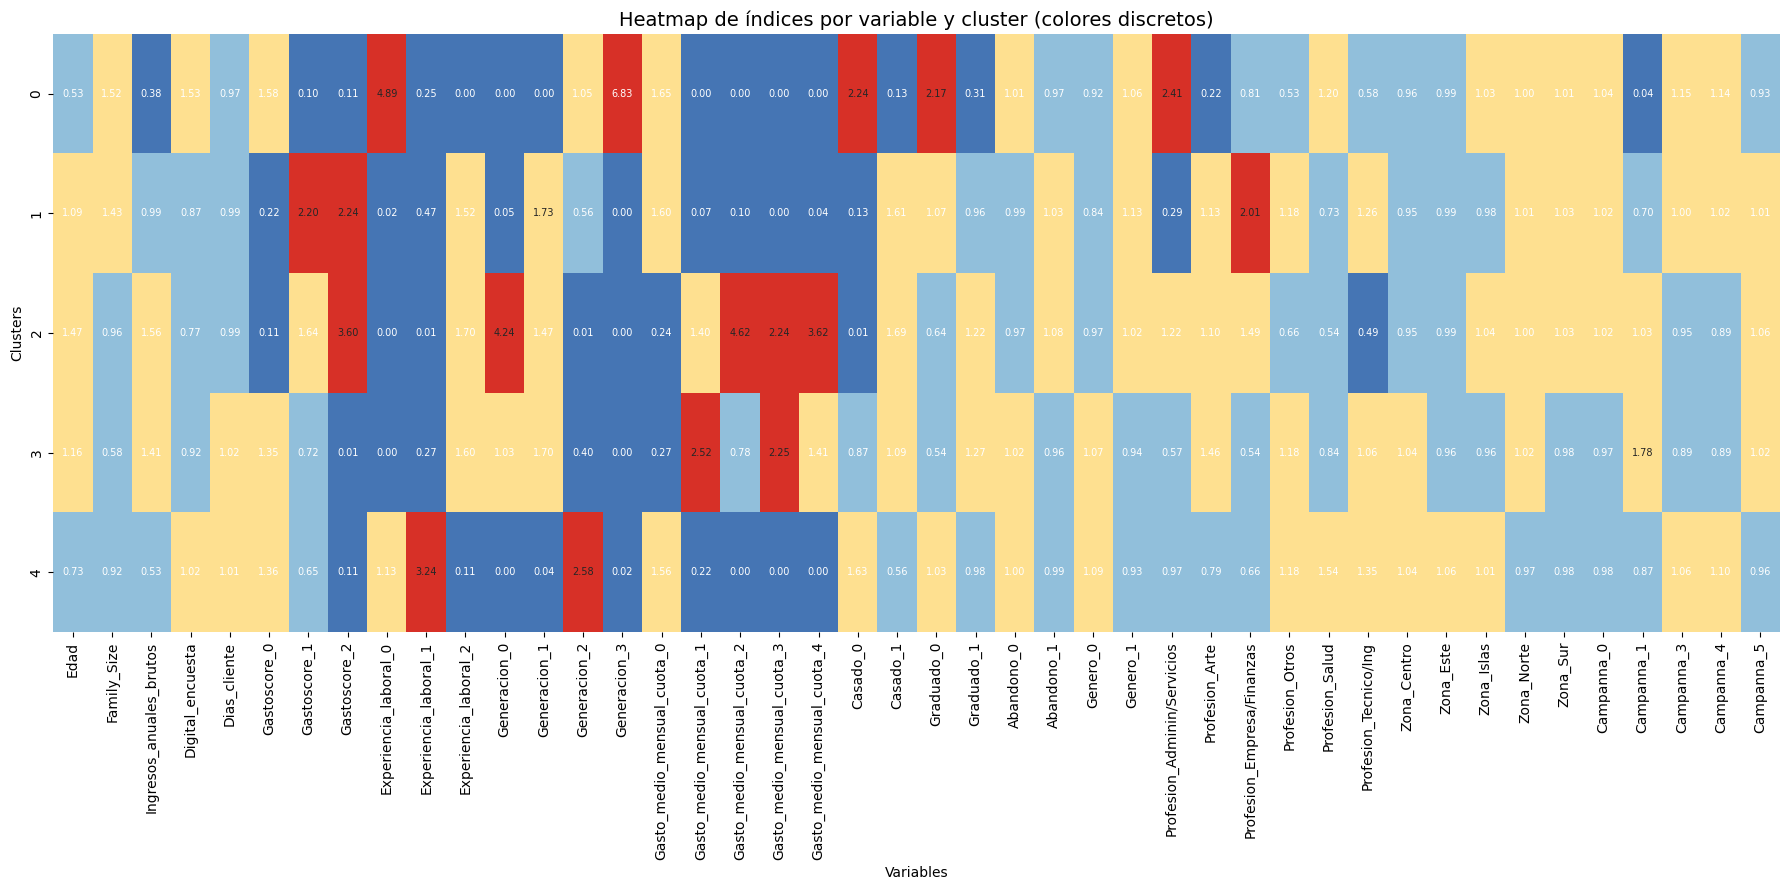

In [11]:
def categorizar_indice(valor):
    if valor < 0.5:
        return "Muy por debajo (<0.5)"
    elif valor < 1:
        return "Por debajo (0.5-1)"
    elif valor < 2:
        return "Por encima (1-2)"
    else:
        return "Muy por encima (≥2)"


categorias = indices.stack().map(categorizar_indice).unstack()


colores = {
    "Muy por debajo (<0.5)": "#4575b4",
    "Por debajo (0.5-1)": "#91bfdb",
    "Por encima (1-2)": "#fee090",
    "Muy por encima (≥2)": "#d73027"
}


colores_matriz = categorias.stack().map(colores).unstack()


plt.figure(figsize=(18, 9))
sns.heatmap(indices, annot=True, fmt=".2f", cmap=list(colores.values()),
            cbar=False, linewidths=0.9, linecolor='gray', mask=indices.isnull(),
            annot_kws={"fontsize": 7}, square=False, xticklabels=True, yticklabels=True)

# Aplicar colores manualmente a cada celda
for i in range(indices.shape[0]):
    for j in range(indices.shape[1]):
        plt.gca().add_patch(plt.Rectangle((j, i), 1, 1,
                                          fill=True, color=colores_matriz.iloc[i, j],
                                          linewidth=0))

plt.title("Heatmap de índices por variable y cluster (colores discretos)", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Clusters")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.show() 


### Comparativa Cluster



La comparación entre clusters se organiza en dos bloques principales:


1) **Perfil del Cliente**

Este bloque describe quiénes son los clientes de cada cluster según sus características personales.

Variables clave:
- Edad, Family_Size, Ingresos_anuales_brutos: media por cluster
- Casado, Graduado: proporción o índice por cluster
- Generacion, Profesion, Zona: top 2 categorías más representadas por cluster (por índice)

2) **Comportamiento frente a la Marca**

Este bloque analiza cómo interactúan los clientes con la empresa.

Variables clave:
- Digital_encuesta, Dias_cliente: media por cluster
- Abandono: proporción de abandono por cluster
- Gastoscore, Experiencia_laboral, Gasto_medio_mensual_cuota: categoría más representada por cluster (por índice)

